# Superpixel learning


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = set_device(verbose=True)

Using backend: pytorch


cuda available


# MNIST Superpixel 

In [2]:
from superpixels import SuperPixDataset
DATASET_NAME = 'MNIST'
dataset = SuperPixDataset(DATASET_NAME)  # 54s
trainset, valset, testset = dataset.train, dataset.val, dataset.test

[I] Loading dataset MNIST...
<_io.BufferedReader name='../Datasets/superpixels/MNIST.pkl'>
train, test, val sizes : 55000 10000 5000
[I] Finished loading.
[I] Data load time: 37.4582s


## Visualise the dataset

Label: tensor(4)
graph: DGLGraph(num_nodes=75, num_edges=600,
         ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float16)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float16)})
Largest eigenvalue: 1.3717939440839868
Smallest eigenvalue: -1.3877787807814457e-17


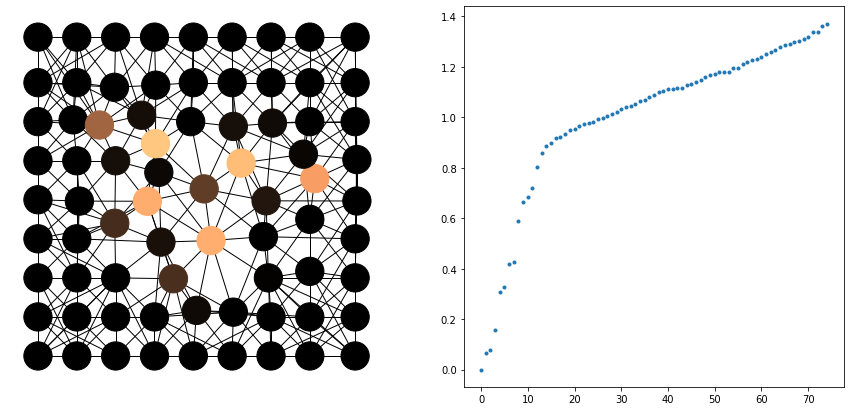

In [3]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo = trainset[random.randrange(45000)]
nx.draw(g_demo.to_networkx().to_undirected(),
        node_color=g_demo.ndata['feat'][:,0],
        pos = g_demo.ndata['feat'][:,1:3].numpy(),
        node_size=800,
        cmap='copper' )

print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()

/home/axel/anaconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


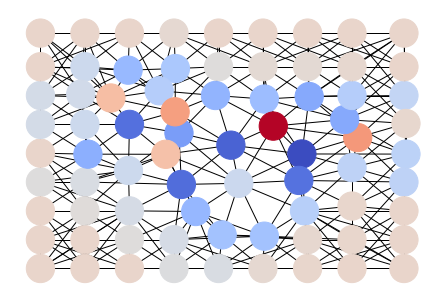

In [4]:
from utils import chebyshev
from laplacian import normalized_laplacian
L = normalized_laplacian(g_demo).to_dense()
Fmap = chebyshev(L,g_demo.ndata['feat'][:,0:3].float() ,3)

nx.draw(g_demo.to_networkx().to_undirected(),
        node_color=Fmap[1][:,0],
        node_size=800,
        pos = g_demo.ndata['feat'][:,1:3].numpy(),
        cmap='coolwarm')

# Model definition for training

In [5]:
from model import DGL_mean_Classifier_modded
# model_parameters
in_features = 3
first_conv_out = 64
second_conv_out = 128
hidden_layer_classifier = 128
k = 4
n_classes = 10

net = DGL_mean_Classifier_modded(
    in_features, 
    first_conv_out, 
    second_conv_out, 
    hidden_layer_classifier, 
    n_classes, k, readout="mean"
)

print(net)
if torch.cuda.is_available():
    net.to(device)

DGL_mean_Classifier_modded(
  (layers): ModuleList(
    (0): Cheb_Conv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=12, out_features=64, bias=True)
      )
    )
    (1): Cheb_Conv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (2): Cheb_Conv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=512, out_features=256, bias=True)
      )
    )
    (3): Cheb_Conv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
  )
  (MLP): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
from utils import load_model
#net.load_state_dict(load_model('Cheb_max_superpix'))

# Training pipe

In [7]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=128,
                          shuffle=True, collate_fn=collate2, drop_last=True, pin_memory=False)
val_loader = DataLoader(valset, batch_size=1000,
                        shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=False)
test_loader = DataLoader(testset, batch_size=1000,
                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=True)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)

epoch_losses = []

In [8]:
def remove_random_edges(G,n):
    ids = np.random.randint(0,G.number_of_edges(), size = n)
    G.remove_edges(ids)

In [9]:
def rm_rand_edges(bG,rate):
    '''
    rate: as a %
    '''
    g_arr = dgl.unbatch(bG)
    for g in g_arr:
        g = remove_random_edges(g,int(g.number_of_edges()*rate))
    return dgl.batch(g_arr)

In [10]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        t0 = time.time()

        for iter, (bGraph, label) in enumerate(data_loader):
            bGraph, label = bGraph.to(device), label.to(device)

            # Random Edge removal
            rm_rand_edges(bGraph, random.uniform(0,0.15))
            #
            
            output = model(bGraph,
                           bGraph.ndata.pop('feat').float().to(device),
                           (torch.ones(2048)*1.4).to(device))
            
            loss = loss_func(output, label.to(device))

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        epoch_loss /= iter + 1

        val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {} loss - train {:.4f} - val {:.4f} - Acc: {} ({:.1f}%) in {:.1f}s".format(
                epoch, epoch_loss, val_loss, correct,
                100 * correct / len(data_loader.dataset), time.time() - t0
            )
        )
        epoch_losses.append([epoch_loss, val_loss])

In [11]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_label = []
    tot_pred = []

    with torch.no_grad():
        for iter, (Bgraph, label) in enumerate(data_loader):
            Bgraph, label = Bgraph.to(device), label.to(device)

            output = model(Bgraph, Bgraph.ndata['feat'].float(
            ), (torch.ones(1000)*1.4).to(device))
            # sum up batch loss
            test_loss += loss_func(output, label.to(device)).item()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

            tot_label.append(label.cpu())
            tot_pred.append(pred.cpu())

    # for the classification report
    tot_label = torch.stack(tot_label).view(-1).cpu()
    tot_pred = torch.stack(tot_pred).view(-1).cpu()

    test_loss /= iter + 1

    if verbose:
        print('\n Average loss per epoch: {:.4f},Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        # BATCHED DGL EXAMPLE
        import sklearn
        from sklearn.metrics import classification_report

        print(sklearn.metrics.classification_report(tot_label, tot_pred, digits=3))

    else:
        return test_loss

## Training time

In [12]:
train(net, device, train_loader, 25, loss_func,optimizer, scheduler)

Epoch 0 loss - train 1.9566 - val 1.6872 - Acc: 14251 (25.9%) in 85.7s
Epoch 1 loss - train 1.3537 - val 1.0101 - Acc: 28230 (51.3%) in 85.6s
Epoch 2 loss - train 0.8896 - val 0.6343 - Acc: 38279 (69.6%) in 85.2s
Epoch 3 loss - train 0.6368 - val 0.5024 - Acc: 43364 (78.8%) in 86.2s
Epoch 4 loss - train 0.5138 - val 0.4256 - Acc: 45695 (83.1%) in 85.9s
Epoch 5 loss - train 0.4355 - val 0.3664 - Acc: 47107 (85.6%) in 88.0s
Epoch 6 loss - train 0.3758 - val 0.3351 - Acc: 48268 (87.8%) in 86.1s
Epoch 7 loss - train 0.3408 - val 0.3041 - Acc: 48873 (88.9%) in 84.5s
Epoch 8 loss - train 0.3011 - val 0.2538 - Acc: 49689 (90.3%) in 87.9s
Epoch 9 loss - train 0.2770 - val 0.2531 - Acc: 50012 (90.9%) in 86.4s
Epoch 10 loss - train 0.2555 - val 0.2815 - Acc: 50407 (91.6%) in 85.2s
Epoch 11 loss - train 0.2367 - val 0.2308 - Acc: 50769 (92.3%) in 85.9s
Epoch 12 loss - train 0.2221 - val 0.2267 - Acc: 51012 (92.7%) in 85.5s
Epoch 13 loss - train 0.2027 - val 0.1976 - Acc: 51405 (93.5%) in 86.1s
Ep

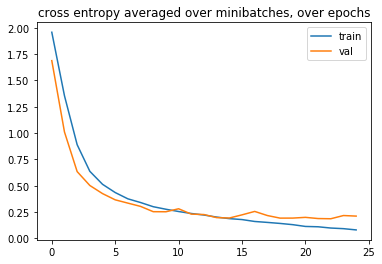

In [13]:
plt.title("cross entropy averaged over minibatches, over epochs")
plt.plot(epoch_losses)
plt.legend(['train','val'])
plt.show()

In [14]:
torch.cuda.empty_cache()

## Test Metrics

In [15]:
test(net,device,test_loader)


 Average loss per epoch: 0.2235,Accuracy: 9353/10000 (94%)

              precision    recall  f1-score   support

           0      0.973     0.973     0.973       980
           1      0.962     0.987     0.974      1135
           2      0.970     0.934     0.952      1032
           3      0.951     0.932     0.941      1010
           4      0.821     0.968     0.888       982
           5      0.934     0.924     0.929       892
           6      0.951     0.968     0.959       958
           7      0.954     0.926     0.940      1028
           8      0.916     0.937     0.926       974
           9      0.936     0.800     0.863      1009

    accuracy                          0.935     10000
   macro avg      0.937     0.935     0.935     10000
weighted avg      0.938     0.935     0.935     10000



## Saving

In [16]:
from utils import save_model

save_model("mnist/Cheb_superpix_mean_dropout_rand", net)
